To convert this for slides:

```
jupyter nbconvert "L23*.ipynb" --to slides --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags remove_input  
```

## Today:

1. **What** to optimize (the "scoring" param in `cross_validate` and `gridsearch`)
1. How to optimize

## What to optimize

### Last time on "LendingClub2013"...

We had two logistic models to predict loan default.

**Model 1** used the default settings:

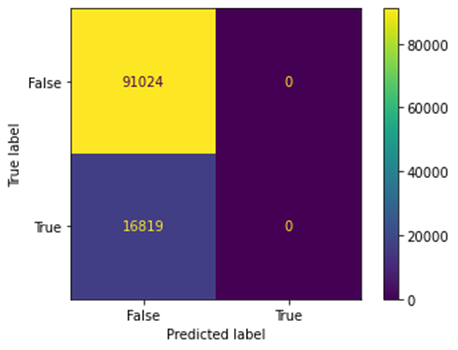

**Model 2** "improved" on this by using one possible fix for **imbalanced classes**:

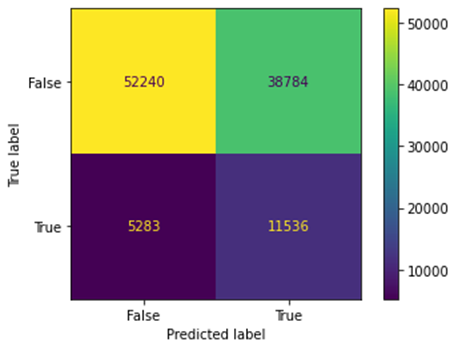

### Exercises

Make (reasonable) assumptions as needed to compare the two models:
1. How much money does this improved model save us relative to the prior model from reduced charge-offs?
1. How much foregone profit does this "improved" model have relative to the prior model?
1. How does this improved model do from the standpoint of a profit maximizing lender? Meaning: Would you rather use the first or the second model, and why? 
1. Write down a profit function for firm using the cells of the confusion matrix. (The four cells of the matrix are TN, TP, FN, and FP.)
1. Based on your profit function, which metric(s) do you want to maximize/minimize in this model? There might not be a clean answer, if so: Discuss candidates and what they capture correctly about the profit function and what they miss.

## How to optimize (hyperparameters)

[As the book says,](https://ledatascifi.github.io/ledatascifi-2022/content/05/04f_optimizing_a_model.html#tuning-hyperparameters)
1. Set up your parameter grids: Start with a wide (and sparse) net.
1. Set up `gridsearchCV` and then `.fit()` it.
1. Plot the performance of the models.

Repeat the above steps as needed, adjusting the parameter grids to hone in on best models,  until you've found an optimized model.


### Let's try that...

I've loaded the LC data. Let's set up the model:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# load data

loans = pd.read_csv('ML - prof only/inputs/2013_subsample.zip')

# create holdout sample

y = loans.loan_status == "Charged Off"
y.value_counts()
loans = loans.drop("loan_status", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    loans, y, stratify=y, test_size=0.2, random_state=0
) # (stratify will make sure that test/train both have equal fractions of outcome)

# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder(drop="first"))

# combine those (make_column_transformer is like make_pipeline, maybe easier on the eyes!)

preproc_pipe = make_column_transformer(
    (numer_pipe, ["annual_inc", "int_rate"]),
    (cat_pipe, ["grade"]),
    remainder="drop",
)

In [3]:
clf_logit = make_pipeline(preproc_pipe, 
                          LogisticRegression(class_weight='balanced'))

When I use `cross_validate` or `gridsearchCV`, I need to pick a scorer to optimize on.

Let's score the models directly on profit. Following the docs, I'll make a custom scorer:

In [4]:
# define the profit function

def custom_prof_score(y, y_pred, roa=0.02, haircut=0.20):
    '''
    Firm profit is this times the average loan size. We can
    ignore that term for the purposes of maximization. 
    '''
    TN = sum((y_pred==0) & (y==0)) # count loans made and actually paid back
    FN = sum((y_pred==0) & (y==1)) # count loans made and actually defaulting
    return TN*roa - FN*haircut

# so that we can use the fcn in sklearn, "make a scorer" out of that function

from sklearn.metrics import make_scorer
prof_score = make_scorer(custom_prof_score)

In this example, we will see if the "regularization" parameter in the logit function matters.

Here, I'm going to try a lot of small values, and then some higher values.

In [5]:
parameters =  {'logisticregression__C': list(np.linspace(0.00001,.5,25))+list(np.linspace(0.55,5.55,6)) }

grid_search = GridSearchCV(estimator = clf_logit, 
                           param_grid = parameters,
                           cv = 5, scoring=prof_score
                           )

In [6]:
results = grid_search.fit(X_train,y_train)

After fitting the `grid_search`, we examine the performance: 

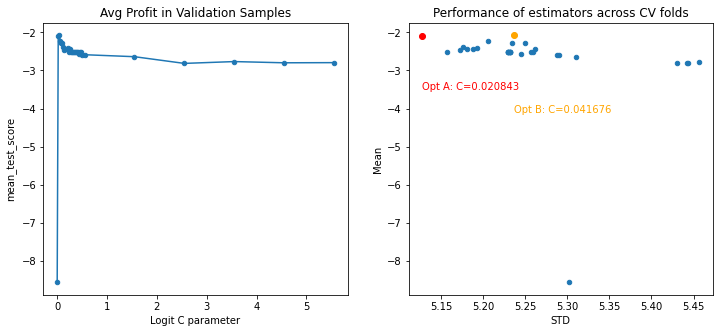

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
(
    pd.DataFrame(results.cv_results_) # get as a DF
    [['param_logisticregression__C','mean_test_score']]
    .plot(kind='line',x='param_logisticregression__C',y='mean_test_score', 
          legend=False,title='Avg Profit in Validation Samples',
          xlabel='Logit C parameter',ax=ax[0])
)    
(
    pd.DataFrame(results.cv_results_) # get as a DF
    [['param_logisticregression__C','mean_test_score']]
    .plot(kind='scatter',x='param_logisticregression__C',y='mean_test_score', 
          legend=False,title='Avg Profit in Validation Samples',
          xlabel='Logit C parameter',ax=ax[0])
)  
(
    pd.DataFrame(results.cv_results_) # get as a DF
    [['std_test_score','mean_test_score']]
    .plot(kind='scatter',x='std_test_score',y='mean_test_score', 
          legend=False,xlabel='STD',ylabel='Mean',
          title='Performance of estimators across CV folds',
         ax=ax[1])
)    

# manually looked for my preferred model
ax[1].scatter(5.127832, -2.088, color='red')
ax[1].text(5.127832, -3.5, 'Opt A: C=0.020843',color='red')

ax[1].scatter(5.236610 	, -2.080, color='orange')
ax[1].text(5.236610 , -4.1, 'Opt B: C=0.041676',color='orange')

plt.show()

- Do you like A or B more?
- How should we adjust the `parameters` grid?

### IMO:

- Option A has nearly the same performance on average with a reasonable reduction in variance
- Option A is probably not the optimal value: Adjust the grid around Option A to look for possible improvements

- To get large (not marginal) gains: We need to upgrade the model
    - Add X vars?
    - Different estimator?

### Next time on "LendingClub2013"...

- Upgrading this model